In [1]:
#1. 패키지 임포트
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

#### pytorch는 신경망 구성하고, 데이터를 로드하고, 모델을 훈련한다.
#### import torch.nn as nn: 신경망을 구축하는 데 필요한 모든 구성 요소(레이어, 활성화 함수)
#### import torch.nn.functional as F: 활성화 함수, 손실 함수 제공
#### import torch.optim as optim: 최적화 알고리즘 제공/SGD(확률적 경사 하강법), Adam 같은 알고리즘
#### from torchvision import datasets,transforms: 이미지 데이터에 대한 표준 데이터 셋과 데이터 전처리 기능 제공
#### from torch.autograd import Variable: 텐서에 대한 연산 추적/자동으로 미분 계산
#### import matplotlib.pyplot as plt: 데이터 시각화를 위한 라이브러리/ 손실,정확도 그래프
#### %matplotlib inline: 해당 노트북 안에서 그래프가 표시되도록 하는 명령어

In [2]:
#2. GPU 사용 체크
is_cuda=False
if torch.cuda.is_available():
    is_cuda = True

In [3]:
# 3. mnist 데이터 다운로드
transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST('data/',train=True,transform=transformation,download=True)
test_dataset = datasets.MNIST('data/',train=False,transform=transformation,download=True)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 32786605.82it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 42148814.83it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31505037.86it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17655726.38it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
#4. 네트워크 정의/신경망의 구조와 순전파 과정을 구현
class Net(nn.Module):
    def __init__(self):
        super().__init__() # 모델의 레이어를 초기화
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) # 1개의 입력 채널을 받아 10개의 출력 채널 생성, 커널 크기는 5
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) # 10개의 입력 채널을 받아 20개의 출력 채널을 생성, 커널 크기는 5
        self.conv2_drop = nn.Dropout2d() # 과적합 방지하기 위해 드롭아웃
        self.fc1 = nn.Linear(320, 50) # 320개의 입력 특성을 받아 50개의 출력 특성을 생성
        self.fc2 = nn.Linear(50, 10) # 50개의 입력 특성을 받아 10개의 출력 특성(틀래스 수) 생성

    def forward(self, x): # 순전파 과정 정의
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # 최대 출링 적용
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320) # 텐서의 모양을 변환하여 완전 연결 레이어에 적합, -1은 해당 차원의 크기를 자동으로 계산하게 함
        x = F.relu(self.fc1(x)) # 첫번 째 완전 연결 레이어 뒤에는 ReLU 활성화 함수 적용
        #x = F.dropout(x,p=0.1, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1) # dim=1은 연산이 적용될 차원을 의미

#### 커널이 크기 5는 임의로 정하는 것?
#### fully connected 레이어 입력 특성 수 정하는 거

In [5]:
#5. 모델 불러오기
model = Net()
if is_cuda:
    model.cuda()

In [6]:
#6. 최적화 함수
optimizer = optim.SGD(model.parameters(),lr=0.01)

In [7]:
#7. 훈련 데이터 변수 준비
data , target = next(iter(train_loader))

#### 학습 데이터 셋의 dataloader에서 첫 번째 배치의 데이터와 타겟을 가져와 data,target 변수에 저장
#### iter 함수로 생성된 반복자(iterator)에서 첫 번째 요소(여기서는 첫 번째 배치)를 가져옵니다. 이 반환값은 데이터(data)와 타겟(target)으로 구성된 튜플입니다. data는 모델 학습에 사용되는 입력 데이터(예: 이미지)를, target은 해당 데이터의 정답 레이블

In [8]:
#8. 훈련 및 검증 함수
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output,target)

        #running_loss += F.nll_loss(output,target,size_average=False).data[0]
        running_loss += F.nll_loss(output,target,reduction='sum').item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()

    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)

    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

####  epoch: 현재 에포크 번호입니다. 에포크는 전체 데이터셋을 한 번 순회하는 것
#### model: 학습 또는 검증에 사용될 신경망 모델
#### data_loader: 현재 단계에서 사용될 데이터셋을 로딩하는 DataLoader 객체
#### phase: 현재 실행 중인 단계를 나타냅니다. 'training' 또는 'validation'의 값
#### volatile: 계산 그래프에 대한 기록을 비활성화하여 메모리 사용량을 줄이는 데 사용/torch.no_grad()를 사용하는 것이 권장

In [9]:
#9. 훈련
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,20):
    epoch_loss, epoch_accuracy = fit(epoch,model,train_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,test_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is  0.56 and training accuracy is 49434/60000     82.39
validation loss is  0.15 and validation accuracy is 9545/10000     95.45
training loss is  0.19 and training accuracy is 56589/60000     94.32
validation loss is 0.093 and validation accuracy is 9711/10000     97.11
training loss is  0.15 and training accuracy is 57393/60000     95.65
validation loss is 0.078 and validation accuracy is 9757/10000     97.57
training loss is  0.13 and training accuracy is 57768/60000     96.28
validation loss is 0.059 and validation accuracy is 9809/10000     98.09
training loss is  0.11 and training accuracy is 58023/60000     96.71
validation loss is 0.055 and validation accuracy is 9820/10000      98.2
training loss is 0.099 and training accuracy is 58191/60000     96.99
validation loss is 0.051 and validation accuracy is 9835/10000     98.35
training loss is 0.093 and training accuracy is 58321/60000      97.2
validation loss is 0.046 and validation accuracy is 9846/10000     98.46

#### 신경망 모델을 학습하고 검증하는 과정을 20번의 에포크(epoch) 동안 반복
#### 학습 손실과 학습 정확도를 각각 train_losses, train_accuracy 리스트에 추가
#### 검증 손실과 검증 정확도를 각각 val_losses, val_accuracy 리스트에 추가

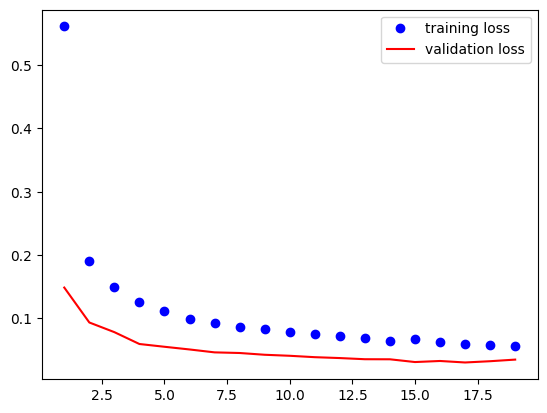

In [10]:
#10. 훈련 데이터와 검증 데이터의 손실 그래프
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

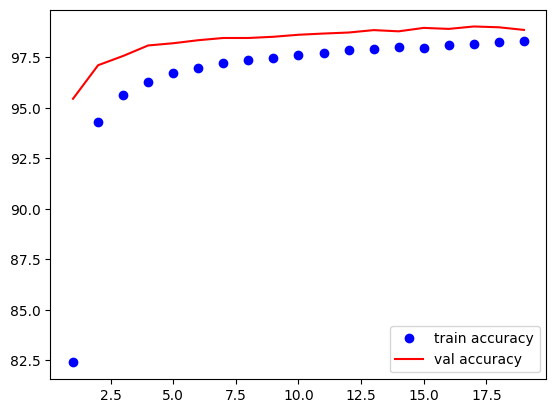

In [11]:
#11. 훈련 데이터와 검증 데이터의 정확도 그래프
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()